# <u>Case Study: Movie Tag Prediction</u>
(Reference: https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags)

#### <u>Abstract</u>: Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies. Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance

## 1) <u>Exploratory Data Analysis</u>

In [1]:
%config IPCompleter.greedy=True
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sqlalchemy import create_engine # database connection
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import stanfordnlp
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
#dumping whole data to sql
if not os.path.isfile("full_data.db"):
    disk_engine = create_engine('sqlite:///full_data.db')
    for df in pd.read_csv('./input/mpst_full_data.csv', delimiter=',',iterator=True, encoding='utf-8'):
        df.to_sql('data', disk_engine, if_exists = 'append')

In [2]:
if os.path.isfile("full_data.db"):
    con = sqlite3.connect("full_data.db")
    df = pd.read_sql_query("Select * from data",con)
    con.close()

In [3]:
df.shape

(14828, 7)

In [4]:
df.head(5)

,index,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [47]:
#check for duplicates
if os.path.isfile("full_data.db"):
    con = sqlite3.connect("full_data.db")
    df = pd.read_sql_query("Select title,plot_synopsis,tags from data",con)
    df_no_duplicates = pd.read_sql_query("Select title,plot_synopsis,tags,split, COUNT(*) as count_dup from data group by title,plot_synopsis,tags",con)
    con.close()

In [48]:
print("shape of de-duplicated dataset is:", df_no_duplicates.shape)

shape of de-duplicated dataset is: (14752, 5)


In [49]:
no_of_dup = df.shape[0]-df_no_duplicates.shape[0]
print("No of duplicate records:",no_of_dup)

No of duplicate records: 76


In [51]:
if not os.path.isfile('data_no_dup.db'):
    disk_dup = create_engine("sqlite:///data_no_dup.db")
    no_dup = pd.DataFrame(df_no_duplicates)
    no_dup.to_sql('data_no_dup',disk_dup)

In [5]:
if os.path.isfile("data_no_dup.db"):
    con = sqlite3.connect("data_no_dup.db")
    df_no_duplicates = pd.read_sql_query("Select * from data_no_dup",con)
    con.close()

In [6]:
df_no_duplicates.head(5)

,index,title,plot_synopsis,tags,split,count_dup
0,0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,1
1,1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,1
2,2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,1
3,3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,1
4,4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,1


#### Let's analyse the number of words in plot_synopsis column

In [7]:
synopis_length = df_no_duplicates["plot_synopsis"].apply(lambda text: len(text.split(' ')))
synopis_length.describe()

count    14752.000000
mean       891.568804
std        881.052819
min         53.000000
25%        425.000000
50%        654.000000
75%        995.000000
max      11405.000000
Name: plot_synopsis, dtype: float64

#### Let's analyse the number of sentences in plot_synopsis column

In [8]:
synopis_sentences = df_no_duplicates["plot_synopsis"].apply(lambda text: len(text.split('.')))
synopis_sentences.describe()

count    14752.000000
mean        50.877237
std         58.385735
min          5.000000
25%         22.000000
50%         35.000000
75%         54.000000
max       1322.000000
Name: plot_synopsis, dtype: float64

#### Let's analyse the tags per movie

In [9]:
no_of_tags_per_movie = df_no_duplicates["tags"].apply(lambda text: len(text.split(', ')))
no_of_tags_per_movie.describe()

count    14752.000000
mean         2.990035
std          2.603397
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         25.000000
Name: tags, dtype: float64

In [10]:
no_of_tags_per_movie_vals = no_of_tags_per_movie.sort_values(ascending = False).values

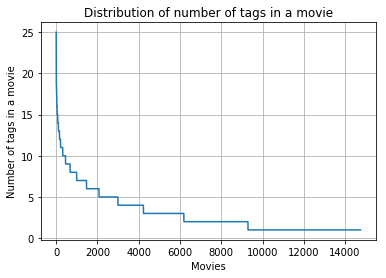

In [11]:
plt.plot(no_of_tags_per_movie_vals)
plt.xlabel("Movies")
plt.ylabel("Number of tags in a movie")
plt.title("Distribution of number of tags in a movie")
plt.grid()
plt.show()

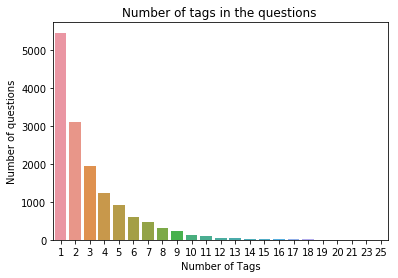

In [12]:
#plot countplot of no of tags per movie
import seaborn as sns
sns.countplot(no_of_tags_per_movie_vals)
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

In [19]:
#analysing the percentiles in no of tags
for q in np.linspace(0,1,11):
    print("{:.2f}th percentile of number of tags is {:.1f}".format(q*100, no_of_tags_per_movie.quantile(q)))

0.00th percentile of number of tags is 1.0
10.00th percentile of number of tags is 1.0
20.00th percentile of number of tags is 1.0
30.00th percentile of number of tags is 1.0
40.00th percentile of number of tags is 2.0
50.00th percentile of number of tags is 2.0
60.00th percentile of number of tags is 3.0
70.00th percentile of number of tags is 3.0
80.00th percentile of number of tags is 5.0
90.00th percentile of number of tags is 6.0
100.00th percentile of number of tags is 25.0


In [20]:
#further zooming in the percentiles
for q in np.linspace(0.9,1,11):
    print("{:.2f}th percentile of number of tags is {:.1f}".format(q*100, no_of_tags_per_movie.quantile(q)))

90.00th percentile of number of tags is 6.0
91.00th percentile of number of tags is 7.0
92.00th percentile of number of tags is 7.0
93.00th percentile of number of tags is 7.0
94.00th percentile of number of tags is 8.0
95.00th percentile of number of tags is 8.0
96.00th percentile of number of tags is 9.0
97.00th percentile of number of tags is 10.0
98.00th percentile of number of tags is 11.0
99.00th percentile of number of tags is 13.0
100.00th percentile of number of tags is 25.0


#### <u>Observation</u>: 97% of movies have less than or equal to 10 tags

In [4]:
#let's analyse tags further
bow = CountVectorizer(tokenizer = lambda x: x.split(', '))
tag_bow = bow.fit_transform(df_no_duplicates["tags"])

In [5]:
print("total no of unique tags: ", tag_bow.shape[1])

total no of unique tags:  71


In [6]:
#print all tags
tags = bow.get_feature_names()
print(tags)

['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 'anti war', 'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christian film', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'good versus evil', 'gothic', 'grindhouse film', 'haunting', 'historical', 'historical fiction', 'home movie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue', 'magical realism', 'melodrama', 'murder', 'mystery', 'neo noir', 'non fiction', 'paranormal', 'philosophical', 'plot twist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer', 'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']


In [22]:
#Lets now store the document term matrix in a dictionary.
tag_freq = tag_bow.sum(axis=0).A1
result = dict(zip(tags, tag_freq))

In [19]:
import csv
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict.csv'):
    with open('tag_counts_dict.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,absurd,270
1,action,659
2,adult comedy,128
3,allegory,138
4,alternate history,102


In [24]:
tag_df_sorted = tag_df.sort_values('Counts',ascending=False)

In [25]:
#print top 20 tags
tag_df_sorted.head(20)

,Tags,Counts
43,murder,5762
68,violence,4420
28,flashback,2937
57,romantic,2894
20,cult,2647
56,revenge,2462
52,psychedelic,1895
17,comedy,1858
65,suspenseful,1086
29,good versus evil,874


### Plotting wordcloud

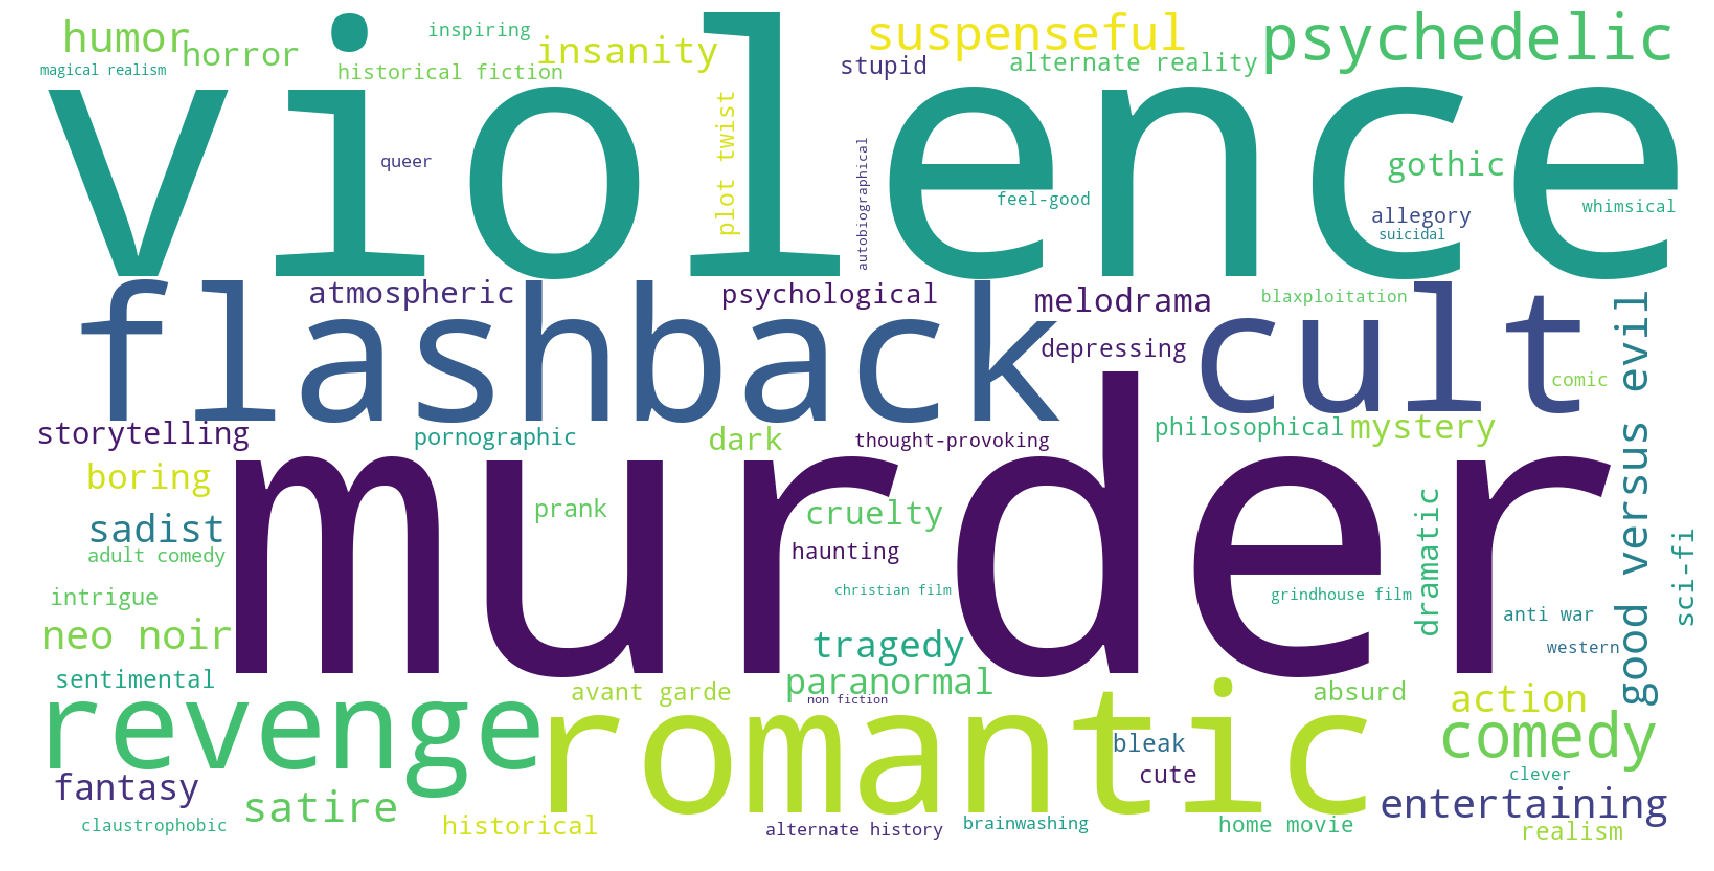

In [26]:
from wordcloud import WordCloud
# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='white',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
#plt.tight_layout(pad=0)
#fig.savefig("tag.png")
plt.show()

### Multi-label statistics

In [41]:
#Calculate label cardinality as per the paper
LC = no_of_tags_per_movie.values.sum()/df_no_duplicates.shape[0]
print("Label cardinality is:", LC)

Label cardinality is: 2.9900352494577005


In [42]:
#Calculate label density as per the paper
LD = LC/tag_bow.shape[1]
print("Label density is:", LD)

Label cardinality is: 0.042113172527573246


##### <u>Note:</u>Cardinality should be lower and density should be higher. But with our results, it might be a harder problem for multi-label classification as cardinality seems high and density seems low

### Correlation between tags: Computing Positive Pointwise mutual information (PPMI) between the tags

In [13]:
#first we will create a dictionary
mainDict = {}
mainDict["Tags"] = tags #this key will contain list all the top words as value
for word in tags:
    mainDict[word] = np.zeros(len(tags)) #other keys of the dictionary will correspond to each word with a list of zeros as value

In [15]:
#we will now convert the dictionary created above to dataframe. This way we will have tags as row and column index
df_corrTags = pd.DataFrame(mainDict).set_index('Tags')

In [51]:
tag_bow_array = tag_bow.toarray()
tag_bow_list = list(tag_bow_array)

In [68]:
#compute PPMI
from tqdm import tqdm
import math
#import pdb
for tag1 in tqdm(tags):
    prob_t1 = tag_df[tag_df["Tags"] == tag1]["Counts"].values[0]/df_no_duplicates.shape[0]
    for tag2 in tags:
        prob_t2 = tag_df[tag_df["Tags"] == tag2]["Counts"].values[0]/df_no_duplicates.shape[0]
        t1_t2_together = list(filter(lambda x: (x[tags.index(tag1)] == 1 and x[tags.index(tag2)] == 1), tag_bow_list))
        #pdb.set_trace()
        prob_t1_t2 = len(t1_t2_together)/df_no_duplicates.shape[0]
        ppmi_t1_t2 = math.log((prob_t1_t2 + 0.0001)/(prob_t1 * prob_t2),2)
        ppmi_t1_t2 = max(ppmi_t1_t2,0)
        df_corrTags[tag1][tag2] = ppmi_t1_t2

100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [03:01<00:00,  3.61s/it]


In [8]:
df_corrTags.head(10)

,absurd,action,adult comedy,allegory,alternate history,alternate reality,anti war,atmospheric,autobiographical,avant garde,...,sentimental,storytelling,stupid,suicidal,suspenseful,thought-provoking,tragedy,violence,western,whimsical
Tags,,,,,,,,,,,,,,,,,,,,,
absurd,5.779668,0.691239,2.412798,2.052189,0.406927,1.733318,1.342076,0.000000,0.873286,2.480710,...,0.000000,1.306237,1.842943,0.577830,0.042805,1.317828,0.000000,0.500868,0.142893,3.220261
action,0.691239,4.487714,0.000000,1.128199,1.564298,0.847232,0.990751,1.699999,0.000000,0.000000,...,0.976108,0.401293,1.935899,0.891553,1.481565,2.067860,1.032994,1.069800,1.377911,1.569613
adult comedy,2.412798,0.000000,6.865155,0.301009,1.973294,0.476688,0.526890,0.000000,1.950102,0.864359,...,0.000000,0.502780,1.973692,2.401281,0.000000,1.249277,0.000000,0.000000,1.219709,1.852387
allegory,2.052189,1.128199,0.301009,6.755439,2.229625,2.812853,2.019408,2.394308,1.841577,2.910625,...,1.778025,0.685216,0.477788,1.546122,1.079890,3.077364,1.403317,0.449813,1.111184,1.743863
alternate history,0.406927,1.564298,1.973294,2.229625,7.196913,4.276776,2.090651,1.630088,2.277677,1.191934,...,2.006936,1.363328,2.059254,1.982221,0.843624,2.431259,0.000000,0.042511,1.547284,2.669513
alternate reality,1.733318,0.847232,0.476688,2.812853,4.276776,6.179487,0.594045,2.210808,1.270622,1.776689,...,1.549113,1.516860,2.240278,0.975166,0.697583,3.304476,0.060097,0.407601,1.286863,3.385809
anti war,1.342076,0.990751,0.526890,2.019408,2.090651,0.594045,6.983904,1.238735,2.067459,2.573526,...,1.263746,0.000000,1.193220,2.518637,0.633406,2.221041,1.629198,0.675695,1.337066,1.223110
atmospheric,0.000000,1.699999,0.000000,2.394308,1.630088,2.210808,1.238735,5.224631,1.067380,2.269541,...,2.081650,1.687615,1.290402,1.626331,2.117169,3.038945,1.501903,0.690449,1.724367,1.817598
autobiographical,0.873286,0.000000,1.950102,1.841577,2.277677,1.270622,2.067459,1.067380,8.436768,1.915377,...,1.832550,2.334308,1.380246,3.195214,0.000000,2.789846,0.504444,0.000000,2.760277,2.646321


In [7]:
import pickle
with open("df_corrTags.pkl","rb") as f:
    df_corrTags = pickle.load(f)

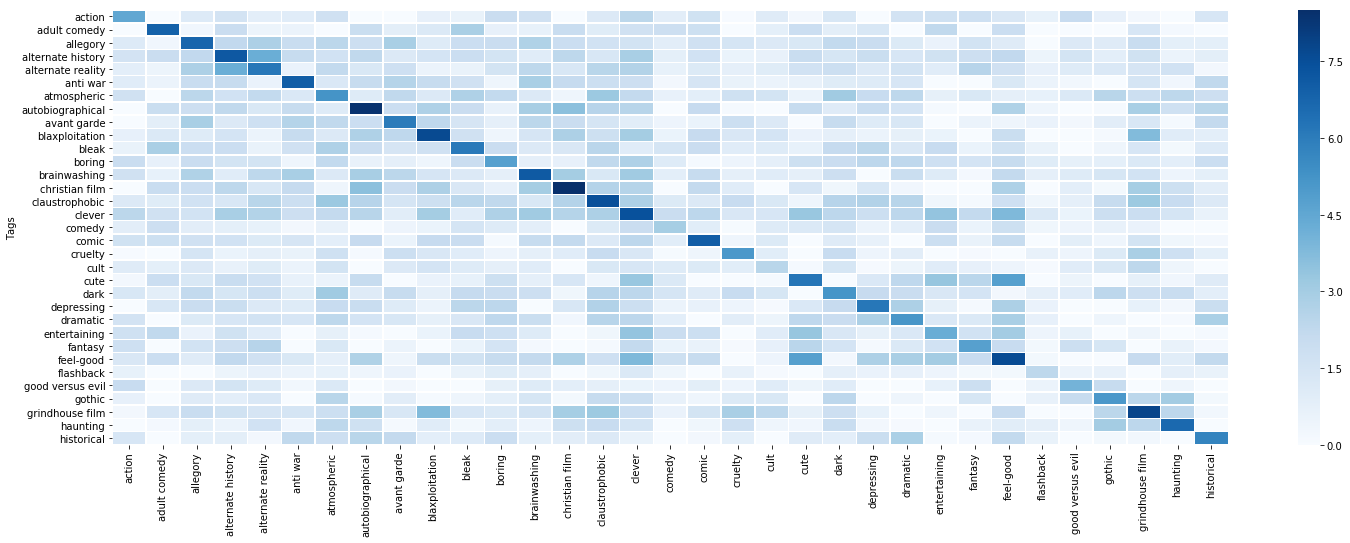

In [56]:
#drawing the heat map for PPMI
import seaborn as sns
fig, ax = plt.subplots(figsize = (25, 8))
g = sns.heatmap(df_corrTags.iloc[1:34,1:34], annot=False, cmap="Blues", linewidths=.5, ax=ax)
#g.set_xticklabels(g.get_xticklabels(), rotation = 45)
plt.show()

##### <u>Note:</u>Heatmap of Positive Pointwise Mutual Information (PPMI) between the tags. Dark blue squares represent high PPMI, and white squares represent low PPMI

##### <u>Observation:</u> We can clearly see the correlation between the tags as suggested in the paper. This indicates that we can generate correlated tags using the plot synopsis

## 2) <u>Performing text pre-processing on Synopsis</u>

In [54]:
#import nltk modules
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

In [55]:
#convert to lowercase
synopsis = df_no_duplicates["plot_synopsis"]
title = df_no_duplicates["title"]
df_no_duplicates["plot_synopsis"] = synopsis.map(lambda x: x.lower())
df_no_duplicates["title"] = title.map(lambda x: x.lower())

In [56]:
#get stopwords to use later
stop_words = set(stopwords.words('English'))
#remove not stopwords which could be useful
stop_words.remove("not")

In [57]:
#get snowball stemmer
sno = SnowballStemmer('english')
print("Done")

Done


In [58]:
#define methods to clean html and punctuations
import re
def RemoveHtml(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', text)
    return cleantext
def RemovePunc(text):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',text)
    #cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = re.sub(r'[,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [59]:
#clean the synopsis before converting them to vectors
import pdb
from tqdm import tqdm
cleaned_synopsis = []
for idx,synopsis in enumerate(tqdm(df_no_duplicates["plot_synopsis"].values)):
    synopsis = RemoveHtml(synopsis)
    synopsis = RemovePunc(synopsis)
    words = synopsis.split()
    stemmed_words=[]
    for word in words:
        if(len(word) > 2 and word not in stop_words):
            stemmed = (sno.stem(word)).encode('utf-8')
            stemmed_words.append(stemmed)
        else:
            continue
    stemmed_synopsis = b" ".join(stemmed_words)   
    cleaned_synopsis.append(stemmed_synopsis)
    #pdb.set_trace()
print("done")

100%|███████████████████████████████████████████████████████████████████████████| 14752/14752 [01:56<00:00, 126.37it/s]


done


In [60]:
#clean the title as well
import pdb
from tqdm import tqdm
cleaned_title = []
for idx,title in enumerate(tqdm(df_no_duplicates["title"].values)):
    title = RemoveHtml(title)
    title = RemovePunc(title)
    words = title.split()
    stemmed_words=[]
    for word in words:
        if(len(word) > 2 and word not in stop_words):
            stemmed = (sno.stem(word)).encode('utf-8')
            stemmed_words.append(stemmed)
        else:
            continue
    stemmed_title = b" ".join(stemmed_words)   
    cleaned_title.append(stemmed_title)
    #pdb.set_trace()
print("done")

100%|█████████████████████████████████████████████████████████████████████████| 14752/14752 [00:00<00:00, 25948.67it/s]


done


In [61]:
#store data in cleaned_data.sqlite
df_no_duplicates["Cleaned_synopsis"] = cleaned_synopsis
df_no_duplicates["Cleaned_synopsis"] = df_no_duplicates["Cleaned_synopsis"].str.decode('utf-8')
df_no_duplicates["Cleaned_title"] = cleaned_title
df_no_duplicates["Cleaned_title"] = df_no_duplicates["Cleaned_title"].str.decode('utf-8')
conn = sqlite3.connect("cleaned_data.sqlite")
c = conn.cursor()
con.text_factory = str
df_no_duplicates.to_sql('Movie_Synopsis', conn, schema=None,if_exists='replace',\
                   index=True, index_label=None, chunksize = None, dtype=None)
conn.close()

In [4]:
#get the data from saved sql database
import os
import sqlite3
import pandas as pd
con = sqlite3.connect("cleaned_data.sqlite")
df = pd.read_sql_query("select title,Cleaned_synopsis,tags from Movie_Synopsis", con)
df.head(5)

,title,Cleaned_synopsis,tags
0,$,set hamburg west germani sever crimin take adv...,murder
1,$windle,6th grader name griffin bing decid gather enti...,flashback
2,'71,gari hook new recruit british armi take leav m...,"suspenseful, neo noir, murder, violence"
3,'a' gai wak,sergeant dragon jacki chan part hong kong mari...,"cult, violence"
4,'breaker' morant,pretoria south africa 1902 major charl bolton ...,"murder, anti war, violence, flashback, tragedy..."


#### Saving the synopis in a text file one sentence per line (to be used in 'Semafor concept of bags')

In [13]:
#final["plot_synopsis"] = final["plot_synopsis"].str.decode('utf-8')
synopis_sentences = final["plot_synopsis"].apply(lambda text: text.split('.'))

In [23]:
f = open("synopis_sentences.txt",encoding="utf-8",mode="w")
from tqdm import tqdm
for synopsis in tqdm(synopis_sentences):
    for sentence in synopsis:
        f.write(sentence + "\n")
f.close()

100%|█████████████████████████████████████████████████████████████████████████| 14752/14752 [00:01<00:00, 10523.81it/s]


#### <u>Note</u>: Semafor didn't work on windows OS

In [8]:
def CreateSqlDB(fileName, data_frame):
    if not os.path.isfile(fileName + ".db"):
        disk_engine = create_engine('sqlite:///'+fileName+'.db')
        data_frame.to_sql('data', disk_engine)

In [2]:
#get the data from saved sql database
import os
import sqlite3
import pandas as pd
con = sqlite3.connect("cleaned_data.sqlite")
df_train = pd.read_sql_query("select title,Cleaned_synopsis,tags from Movie_Synopsis where split<>'test'", con)
df_test = pd.read_sql_query("select title,Cleaned_synopsis,tags from Movie_Synopsis where split='test'", con)
con.close()

In [9]:
#dump train, test (without val) dataset to SQL DBs
CreateSqlDB("df_train_noval",df_train)
CreateSqlDB("df_test_noval",df_test)

## 3) <u>Define random and majority baseline models</u>

### <u>Important Note</u>: I will use Micro-F1 score and tag recall (Macro-Recall) score as scoring metric for baseline and all the other models as suggested in the paper

### <u>Important Note: </u> The average number of tags per movie is approximately three.Thus I will check three type of test score, 1st I will predict the tags normally and check the test score, in second part I will predict fixed 3 number of tags and lastly I will predict fixed 5 number of tags to get more detailed idea about the movie by checking the test scores

### Random Model

In [17]:
tag_df = pd.read_csv("tag_counts_dict.csv", names=['Tags', 'Counts'])

In [18]:
random_3_tags = tag_df.sample(3)["Tags"].values
random_3_tags = "{0}, {1}, {2}".format(random_3_tags[0], random_3_tags[1], random_3_tags[2])
random_5_tags = tag_df.sample(5)["Tags"].values
random_5_tags = "{0}, {1}, {2}, {3}, {4}".format(random_5_tags[0], random_5_tags[1], random_5_tags[2], random_5_tags[3], random_5_tags[4])

In [19]:
#define train and test dataset for majority baseline top 3 and 5 tags
df_test["random_tags_3"] = random_3_tags
df_test["random_tags_5"] = random_5_tags

In [21]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train["tags"])
y_test_random3 = bow.transform(df_test["random_tags_3"])
y_test_random5 = bow.transform(df_test["random_tags_5"])
y_test = bow.transform(df_test["tags"])

In [22]:
#f1-score for random 3 model
f1 = f1_score(y_test, y_test_random3, average='micro')
print("Micro-F1 score: {:.2f}".format(f1 * 100))
recall = recall_score(y_test, y_test_random3, average='macro')
print("Macro-Recall score: {:.3f}".format(recall * 100))

Micro-F1 score: 2.04
Macro-Recall score: 4.225


In [23]:
#f1-score for random 5 model
f1 = f1_score(y_test, y_test_random5, average='micro')
print("Micro-F1 score: {:.2f}".format(f1 * 100))
recall = recall_score(y_test, y_test_random5, average='macro')
print("Macro-Recall score: {:.3f}".format(recall * 100))

Micro-F1 score: 1.01
Macro-Recall score: 7.042


### Majority Model

In [3]:
tag_df = pd.read_csv("tag_counts_dict.csv", names=['Tags', 'Counts'])
tag_df_sorted = tag_df.sort_values('Counts',ascending=False)

In [4]:
top_3_tags = tag_df_sorted.iloc[0:3]["Tags"].values
top_3_tags = "{0}, {1}, {2}".format(top_3_tags[0], top_3_tags[1], top_3_tags[2])
top_5_tags = tag_df_sorted.iloc[0:5]["Tags"].values
top_5_tags = "{0}, {1}, {2}, {3}, {4}".format(top_5_tags[0], top_5_tags[1], top_5_tags[2], top_5_tags[3], top_5_tags[4])

In [5]:
#define train and test dataset for majority baseline top 3 and 5 tags
df_test["majority_tags_3"] = top_3_tags
df_test["majority_tags_5"] = top_5_tags

In [8]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train["tags"])
y_test_major3 = bow.transform(df_test["majority_tags_3"])
y_test_major5 = bow.transform(df_test["majority_tags_5"])
y_test = bow.transform(df_test["tags"])

In [9]:
#f1-score for majority 3 model
f1 = f1_score(y_test, y_test_major3, average='micro')
print("Micro-F1 score: {:.2f}".format(f1 * 100))
recall = recall_score(y_test, y_test_major3, average='macro')
print("Macro-Recall score: {:.3f}".format(recall * 100))

Micro-F1 score: 29.74
Macro-Recall score: 4.225


In [10]:
#f1-score for majority 5 model
f1 = f1_score(y_test, y_test_major5, average='micro')
print("Micro-F1 score: {:.2f}".format(f1 * 100))
recall = recall_score(y_test, y_test_major5, average='macro')
print("Macro-Recall score: {:.3f}".format(recall * 100))

Micro-F1 score: 31.91
Macro-Recall score: 7.042


## 4) <u>Modelling</u>
<u>Note</u>: We'll use Logistic regression with OVR Classifier for modelling

### Define  utility methods for Logistic Regression Model with hyper-parameter tuning

In [2]:
#Perform grid search for logistic regression
from time import time
from sklearn.model_selection import GridSearchCV
def PerformGridSearchCV(estimator,parameters, cv, scoring, X_train, y_train):
    clf = GridSearchCV(estimator = estimator, param_grid = parameters, cv=cv, scoring = scoring, n_jobs = -1, verbose = 1)
    start = time()
    clf.fit(X_train, y_train)
    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(clf.cv_results_['params'])))
    report(clf.cv_results_)
    return clf.cv_results_,clf.best_score_ ,clf.best_estimator_

In [3]:
# Utility function to report best scores
#reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
def PlotTrainVsCVerror(cv_results, score_type):
    """plotting misclassification train and CV error against given alpha values for a given score metric"""
    df_grid_results = pd.DataFrame(cv_results)
    grd_srch_test = df_grid_results["mean_test_score"].values
    grd_srch_train = df_grid_results["mean_train_score"].values
    alphaValues = df_grid_results["param_estimator__alpha"].values
    plt.figure(figsize=(10,5))
    plt.plot(alphaValues, grd_srch_train, 'r-', label= 'Train Metric score')
    plt.plot(alphaValues, grd_srch_test, 'b-', label= 'CV Metric score')
    plt.xlabel('alphas')
    plt.ylabel('Metric Score')
    plt.title("Train & CV Metric score plot for " + score_type)
    plt.legend(loc='best')
    plt.show()

In [5]:
#Check the test performance with tuned hyper-parameter
def CheckTestScores(classifier,X_train,y_train,X_test,y_test,bow):
    classifier.fit(X_train, y_train)
    predict_proba = classifier.predict_proba(X_test)
    predictions = classifier.predict(X_test)
    fnames = bow.get_feature_names()
    fix_3_tags = []
    fix_5_tags = []
    counter=0
    for index, row in df_test_noval.iterrows():
        counter += 1
        movie_prob = predict_proba.argsort()[counter-1][::-1]
        #movie_prob = predict_proba.argsort()[index][::-1]
        #get the 3 tags with max probability
        fix_3_tags.append("{0}, {1}, {2}".format(fnames[movie_prob[0]], fnames[movie_prob[1]], fnames[movie_prob[2]]))
        #get the 5 tags with max probability
        fix_5_tags.append("{0}, {1}, {2}, {3}, {4}".format(fnames[movie_prob[0]], fnames[movie_prob[1]], fnames[movie_prob[2]], fnames[movie_prob[3]], fnames[movie_prob[4]]))
    
    df_test_noval["fix_3_tags"] = fix_3_tags
    df_test_noval["fix_5_tags"] = fix_5_tags
    y_test_max3 = bow.transform(df_test_noval["fix_3_tags"])
    y_test_max5 = bow.transform(df_test_noval["fix_5_tags"]) 
    #micro f1-score without fixed no of tags
    f1 = f1_score(y_test, predictions, average='micro')
    print("Micro-F1 score without fixed no of tags: {:.2f}".format(f1 * 100))
    #macro recall score without fixed no of tags
    recall = recall_score(y_test, predictions, average='macro')
    print("Macro-Recall score without fixed no of tags: {:.3f}".format(recall * 100))
    #f1-score for fixed 3 tags
    f1 = f1_score(y_test, y_test_max3, average='micro')
    print("Micro-F1 score for fixed 3 tags: {:.2f}".format(f1 * 100))
    #macro recall score for fixed 3 tags
    recall = recall_score(y_test, y_test_max3, average='macro')
    print("Macro-Recall score for fixed 3 tags: {:.3f}".format(recall * 100))
    #f1-score for fixed 3 tags
    f1 = f1_score(y_test, y_test_max5, average='micro')
    print("Micro-F1 score for fixed 5 tags: {:.2f}".format(f1 * 100))
    #macro recall score for fixed 5 tags
    recall = recall_score(y_test, y_test_max5, average='macro')
    print("Macro-Recall score for fixed 5 tags: {:.3f}".format(recall * 100))

In [6]:
#get the train, test and val datasets
def GetSqlDB(fileName):
    if os.path.isfile(fileName):
        con = sqlite3.connect(fileName)
        df = pd.read_sql_query("Select * from data",con)
        con.close()
        return df

## <u>4.1: Uni-gram, Bi-gram and tri-gram in TFIDF Vectorizer</u>
<u>Note</u>: We will use TFIDF Vectorizer as it has shown to give the best results

### 1-Gram TFIDF

In [6]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [7]:
df_train_noval.head(5)

,index,title,Cleaned_synopsis,tags
0,0,$windle,6th grader name griffin bing decid gather enti...,flashback
1,1,'71,gari hook new recruit british armi take leav m...,"suspenseful, neo noir, murder, violence"
2,2,'a' gai wak,sergeant dragon jacki chan part hong kong mari...,"cult, violence"
3,3,'breaker' morant,pretoria south africa 1902 major charl bolton ...,"murder, anti war, violence, flashback, tragedy..."
4,4,'c'-man,custom investig cliff holden dean jagger retur...,murder


In [8]:
#1-gram
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
X_tfidf_1gram_train = tfidf_vect.fit_transform(df_train_noval["Cleaned_synopsis"].values)
X_tfidf_1gram_test = tfidf_vect.transform(df_test_noval["Cleaned_synopsis"].values)

In [9]:
print(X_tfidf_1gram_train.shape)
print(X_tfidf_1gram_test.shape)

(11797, 104924)
(2955, 104924)


In [10]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x000001DA842E1620>,
        vocabulary=None)

#### Using GridSearchCV to find the optimal alpha value

In [11]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


In [12]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_tfidf_1gram_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.4min finished


GridSearchCV took 150.81 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.272 (std: 0.005)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 2
Mean validation score: 0.192 (std: 0.005)
Parameters: {'estimator__alpha': 0.0001}

Model with rank: 3
Mean validation score: 0.170 (std: 0.058)
Parameters: {'estimator__alpha': 100}

Model with rank: 4
Mean validation score: 0.105 (std: 0.088)
Parameters: {'estimator__alpha': 10}

Model with rank: 5
Mean validation score: 0.039 (std: 0.078)
Parameters: {'estimator__alpha': 1}



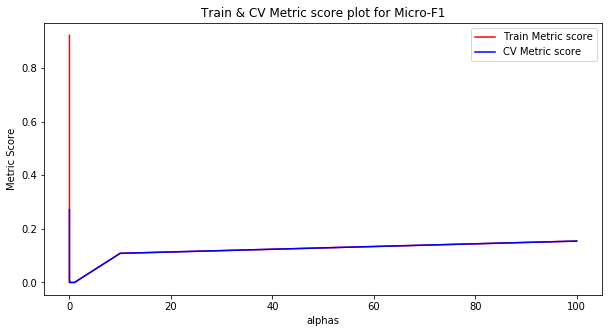

In [14]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [15]:
#Check the test performance with tuned hyper-parameter using grid search
best_alpha = best_estimator.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', alpha = best_alpha), n_jobs=-1)
CheckTestScores(classifier, X_tfidf_1gram_train,y_train,X_tfidf_1gram_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 30.07
Macro-Recall score without fixed no of tags: 7.139
Micro-F1 score for fixed 3 tags: 33.75
Macro-Recall score for fixed 3 tags: 11.199
Micro-F1 score for fixed 5 tags: 34.19
Macro-Recall score for fixed 5 tags: 17.016


### 2-Gram TFIDF

In [8]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [9]:
#2-gram
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(2,2))
X_tfidf_2gram_train = tfidf_vect.fit_transform(df_train_noval["Cleaned_synopsis"].values)
X_tfidf_2gram_test = tfidf_vect.transform(df_test_noval["Cleaned_synopsis"].values)

In [10]:
print(X_tfidf_2gram_train.shape)
print(X_tfidf_2gram_test.shape)

(11797, 3266474)
(2955, 3266474)


In [11]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x000001E14A96FD90>,
        vocabulary=None)

In [12]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


#### Using GridSearchCV to find the optimal alpha value

In [14]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_tfidf_2gram_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 19.1min finished


GridSearchCV took 1184.47 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.166 (std: 0.059)
Parameters: {'estimator__alpha': 100}

Model with rank: 2
Mean validation score: 0.155 (std: 0.011)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 3
Mean validation score: 0.057 (std: 0.076)
Parameters: {'estimator__alpha': 10}

Model with rank: 4
Mean validation score: 0.006 (std: 0.002)
Parameters: {'estimator__alpha': 0.0001}

Model with rank: 5
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 0.001}

Model with rank: 5
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 0.01}

Model with rank: 5
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 0.1}

Model with rank: 5
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 1}



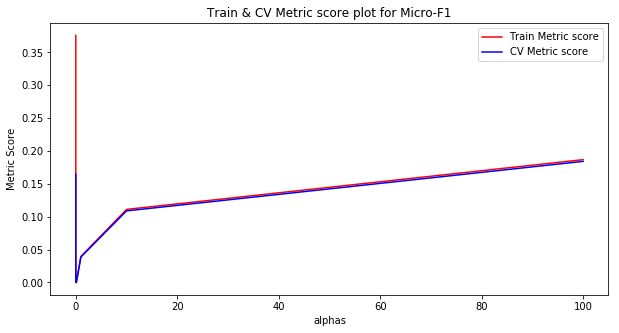

In [13]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [10]:
#Check the test performance with tuned hyper-parameter using grid search
best_alpha = best_estimator.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', alpha = best_alpha), n_jobs=-1)
CheckTestScores(classifier,X_tfidf_2gram_train,y_train,X_tfidf_2gram_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 25.01
Macro-Recall score without fixed no of tags: 2.964
Micro-F1 score for fixed 3 tags: 35.79
Macro-Recall score for fixed 3 tags: 6.837
Micro-F1 score for fixed 5 tags: 35.62
Macro-Recall score for fixed 5 tags: 10.153


### 3-Gram TFIDF

In [4]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [5]:
#3-gram
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(3,3))
X_tfidf_3gram_train = tfidf_vect.fit_transform(df_train_noval["Cleaned_synopsis"].values)
X_tfidf_3gram_test = tfidf_vect.transform(df_test_noval["Cleaned_synopsis"].values)

In [6]:
print(X_tfidf_3gram_train.shape)
print(X_tfidf_3gram_test.shape)

(11797, 5419930)
(2955, 5419930)


In [7]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x0000020B1E21F158>,
        vocabulary=None)

In [8]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


#### Using GridSearchCV to find the optimal alpha value

In [13]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_tfidf_3gram_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 21.4min finished


GridSearchCV took 1328.88 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.138 (std: 0.055)
Parameters: {'estimator__alpha': 100}

Model with rank: 2
Mean validation score: 0.087 (std: 0.072)
Parameters: {'estimator__alpha': 10}

Model with rank: 3
Mean validation score: 0.006 (std: 0.001)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 4
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 0.0001}

Model with rank: 4
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 0.001}

Model with rank: 4
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 0.01}

Model with rank: 4
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 0.1}

Model with rank: 4
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 1}



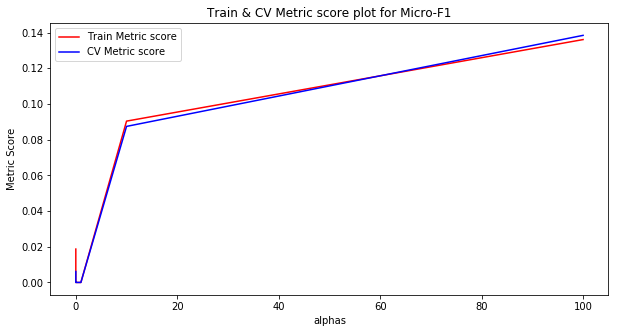

In [14]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [10]:
#Check the test performance with tuned hyper-parameter using grid search
best_alpha = best_estimator.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', alpha = best_alpha), n_jobs=-1)
CheckTestScores(classifier,X_tfidf_3gram_train,y_train,X_tfidf_3gram_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 9.43
Macro-Recall score without fixed no of tags: 0.750
Micro-F1 score for fixed 3 tags: 30.78
Macro-Recall score for fixed 3 tags: 4.700
Micro-F1 score for fixed 5 tags: 32.54
Macro-Recall score for fixed 5 tags: 7.577


### 1+2+3-Gram TFIDF

In [4]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [5]:
#1+2+3-gram
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1,3))
X_tfidf_123gram_train = tfidf_vect.fit_transform(df_train_noval["Cleaned_synopsis"].values)
X_tfidf_123gram_test = tfidf_vect.transform(df_test_noval["Cleaned_synopsis"].values)

In [6]:
print(X_tfidf_123gram_train.shape)
print(X_tfidf_123gram_test.shape)

(11797, 8791328)
(2955, 8791328)


In [7]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x00000289F2B4F510>,
        vocabulary=None)

In [8]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


#### Using GridSearchCV to find the optimal alpha value

In [14]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_tfidf_123gram_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 40.8min finished


GridSearchCV took 2530.76 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.264 (std: 0.004)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 2
Mean validation score: 0.150 (std: 0.002)
Parameters: {'estimator__alpha': 0.0001}

Model with rank: 3
Mean validation score: 0.149 (std: 0.054)
Parameters: {'estimator__alpha': 100}

Model with rank: 4
Mean validation score: 0.122 (std: 0.109)
Parameters: {'estimator__alpha': 10}

Model with rank: 5
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 0.001}

Model with rank: 5
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 0.01}

Model with rank: 5
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 0.1}

Model with rank: 5
Mean validation score: 0.000 (std: 0.000)
Parameters: {'estimator__alpha': 1}



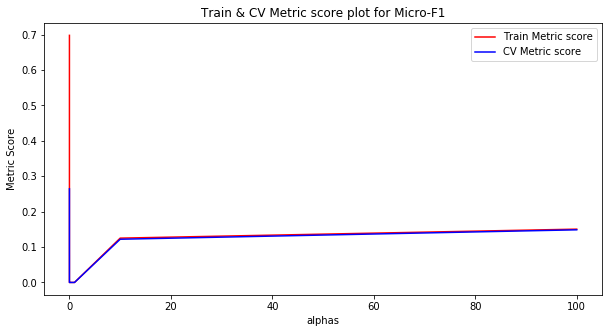

In [15]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [9]:
#Check the test performance with tuned hyper-parameter using grid search
best_alpha = best_estimator.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', alpha = best_alpha), n_jobs=-1)
CheckTestScores(classifier,X_tfidf_123gram_train,y_train,X_tfidf_123gram_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 35.21
Macro-Recall score without fixed no of tags: 9.429
Micro-F1 score for fixed 3 tags: 36.04
Macro-Recall score for fixed 3 tags: 11.277
Micro-F1 score for fixed 5 tags: 36.23
Macro-Recall score for fixed 5 tags: 16.849


## <u>4.2: Char Grams</u>
<u>Note</u> : We will use TFIDF Vectorizer as it has shown to give the best results

### Char 3-Gram TFIDF

In [4]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [5]:
#char 3-gram
tfidf_vect = TfidfVectorizer(ngram_range=(3, 3), analyzer='char')
X_tfidf_char3gram_train = tfidf_vect.fit_transform(df_train_noval["Cleaned_synopsis"].values)
X_tfidf_char3gram_test = tfidf_vect.transform(df_test_noval["Cleaned_synopsis"].values)

In [6]:
print(X_tfidf_char3gram_train.shape)
print(X_tfidf_char3gram_test.shape)

(11797, 28103)
(2955, 28103)


In [7]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x0000014F10E06D08>,
        vocabulary=None)

In [8]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


#### Using GridSearchCV to find the optimal alpha value

In [23]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_tfidf_char3gram_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.1min finished


GridSearchCV took 382.53 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.288 (std: 0.010)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 2
Mean validation score: 0.197 (std: 0.002)
Parameters: {'estimator__alpha': 0.0001}

Model with rank: 3
Mean validation score: 0.152 (std: 0.042)
Parameters: {'estimator__alpha': 100}

Model with rank: 4
Mean validation score: 0.078 (std: 0.096)
Parameters: {'estimator__alpha': 10}

Model with rank: 5
Mean validation score: 0.041 (std: 0.003)
Parameters: {'estimator__alpha': 0.001}



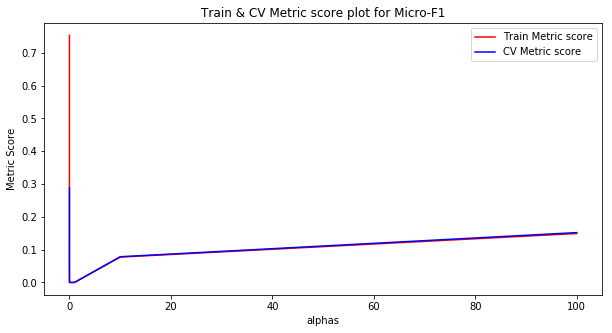

In [24]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [9]:
#Check the test performance with tuned hyper-parameter using grid search
best_alpha = best_estimator.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', alpha = best_alpha), n_jobs=-1)
CheckTestScores(classifier,X_tfidf_char3gram_train,y_train,X_tfidf_char3gram_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 30.02
Macro-Recall score without fixed no of tags: 6.037
Micro-F1 score for fixed 3 tags: 33.58
Macro-Recall score for fixed 3 tags: 11.241
Micro-F1 score for fixed 5 tags: 33.63
Macro-Recall score for fixed 5 tags: 17.244


### Char 4-Gram TFIDF

In [4]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [5]:
#char 4-gram
tfidf_vect = TfidfVectorizer(ngram_range=(4, 4), analyzer='char')
X_tfidf_char4gram_train = tfidf_vect.fit_transform(df_train_noval["Cleaned_synopsis"].values)
X_tfidf_char4gram_test = tfidf_vect.transform(df_test_noval["Cleaned_synopsis"].values)

In [6]:
print(X_tfidf_char4gram_train.shape)
print(X_tfidf_char4gram_test.shape)

(11797, 157854)
(2955, 157854)


In [7]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x00000290D5A85EA0>,
        vocabulary=None)

In [8]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


#### Using GridSearchCV to find the optimal alpha value

In [12]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_tfidf_char4gram_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 15.1min finished


GridSearchCV took 942.92 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.283 (std: 0.005)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 2
Mean validation score: 0.182 (std: 0.004)
Parameters: {'estimator__alpha': 0.0001}

Model with rank: 3
Mean validation score: 0.111 (std: 0.044)
Parameters: {'estimator__alpha': 100}

Model with rank: 4
Mean validation score: 0.095 (std: 0.119)
Parameters: {'estimator__alpha': 10}

Model with rank: 5
Mean validation score: 0.014 (std: 0.003)
Parameters: {'estimator__alpha': 0.001}



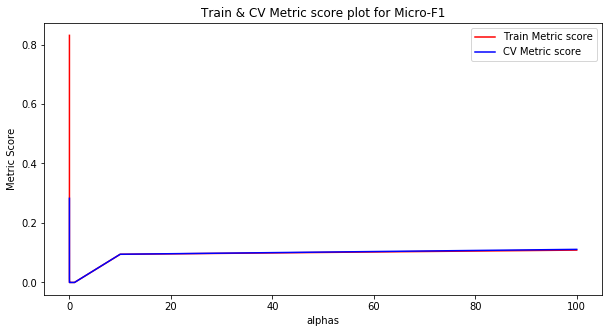

In [13]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [9]:
#Check the test performance with tuned hyper-parameter using grid search
best_alpha = best_estimator.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', alpha = best_alpha), n_jobs=-1)
CheckTestScores(classifier,X_tfidf_char4gram_train,y_train,X_tfidf_char4gram_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 29.24
Macro-Recall score without fixed no of tags: 5.583
Micro-F1 score for fixed 3 tags: 34.62
Macro-Recall score for fixed 3 tags: 10.650
Micro-F1 score for fixed 5 tags: 35.04
Macro-Recall score for fixed 5 tags: 16.877


### Char 3-4-Gram TFIDF

In [6]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [7]:
#char 3-4-gram
tfidf_vect = TfidfVectorizer(ngram_range=(3, 4), analyzer='char')
X_tfidf_char34gram_train = tfidf_vect.fit_transform(df_train_noval["Cleaned_synopsis"].values)
X_tfidf_char34gram_test = tfidf_vect.transform(df_test_noval["Cleaned_synopsis"].values)

In [8]:
print(X_tfidf_char34gram_train.shape)
print(X_tfidf_char34gram_test.shape)

(11797, 185957)
(2955, 185957)


In [9]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x000002BC4E789598>,
        vocabulary=None)

In [10]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


#### Using GridSearchCV to find the optimal alpha value

In [11]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_tfidf_char34gram_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 31.6min finished


GridSearchCV took 1979.06 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.287 (std: 0.009)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 2
Mean validation score: 0.172 (std: 0.005)
Parameters: {'estimator__alpha': 0.0001}

Model with rank: 3
Mean validation score: 0.136 (std: 0.077)
Parameters: {'estimator__alpha': 100}

Model with rank: 4
Mean validation score: 0.056 (std: 0.113)
Parameters: {'estimator__alpha': 10}

Model with rank: 5
Mean validation score: 0.005 (std: 0.002)
Parameters: {'estimator__alpha': 0.001}



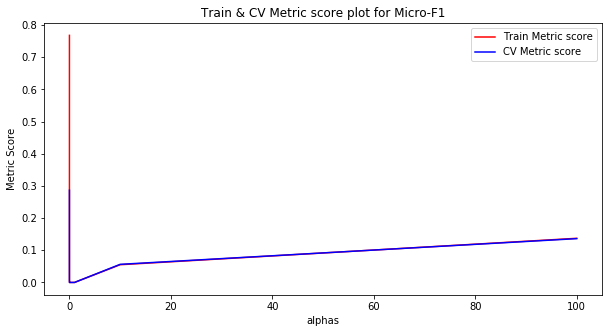

In [14]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [15]:
#Check the test performance with tuned hyper-parameter using grid search
best_alpha = best_estimator.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', alpha = best_alpha), n_jobs=-1)
CheckTestScores(classifier,X_tfidf_char34gram_train,y_train,X_tfidf_char34gram_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 29.09
Macro-Recall score without fixed no of tags: 5.111
Micro-F1 score for fixed 3 tags: 35.36
Macro-Recall score for fixed 3 tags: 10.514
Micro-F1 score for fixed 5 tags: 35.49
Macro-Recall score for fixed 5 tags: 16.417


## <u>4.3: Skip Grams</u>
<u>Note</u>: We will use TFIDF Vectorizer as it has shown to give the best results

### 2 Skip 2-Gram TFIDF

In [4]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [5]:
#reference: https://stackoverflow.com/questions/39725052/implementing-skip-gram-with-scikit-learn
from Skipgram import SkipGramVectorizer

In [6]:
skipgram_vect = SkipGramVectorizer(ngram_range=(2,2), k=2) #2 skip bi-gram
X_skipgram_2skip2_train = skipgram_vect.fit_transform(df_train_noval["Cleaned_synopsis"].values)
X_skipgram_2skip2_test = skipgram_vect.transform(df_test_noval["Cleaned_synopsis"].values)

In [7]:
print(X_skipgram_2skip2_train.shape)
print(X_skipgram_2skip2_test.shape)

(11797, 7478170)
(2955, 7478170)


In [8]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x000001BAA39FAE18>,
        vocabulary=None)

In [9]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


#### Using GridSearchCV to find the optimal alpha value

In [13]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_skipgram_2skip2_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 53.1min finished


GridSearchCV took 3295.03 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.137 (std: 0.009)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 2
Mean validation score: 0.115 (std: 0.074)
Parameters: {'estimator__alpha': 10}

Model with rank: 3
Mean validation score: 0.085 (std: 0.068)
Parameters: {'estimator__alpha': 100}

Model with rank: 4
Mean validation score: 0.039 (std: 0.078)
Parameters: {'estimator__alpha': 1}

Model with rank: 5
Mean validation score: 0.001 (std: 0.001)
Parameters: {'estimator__alpha': 0.0001}



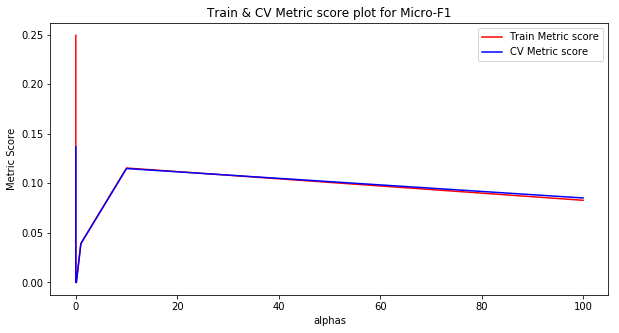

In [14]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [10]:
#Check the test performance with tuned hyper-parameter using grid search
best_alpha = best_estimator.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', alpha = best_alpha), n_jobs=-1)
CheckTestScores(classifier,X_skipgram_2skip2_train,y_train,X_skipgram_2skip2_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 21.96
Macro-Recall score without fixed no of tags: 1.988
Micro-F1 score for fixed 3 tags: 35.17
Macro-Recall score for fixed 3 tags: 6.115
Micro-F1 score for fixed 5 tags: 35.19
Macro-Recall score for fixed 5 tags: 9.078


## <u>4.4: Using fast text average word vectors</u>

In [6]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [4]:
from gensim.models import KeyedVectors
en_model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

In [5]:
fasttext_words = list(en_model.wv.vocab)

In [6]:
def Get_List_Synopsis(X_type):
    """get list of words for all synopsis for the given X_type"""
    list_of_synopsis = []
    for synopsis in X_type.values:
        list_of_synopsis.append(synopsis.split())
    return list_of_synopsis

In [7]:
#converting train synposis into list of words for each review
list_of_synopsis_train = Get_List_Synopsis(df_train_noval["Cleaned_synopsis"])
print(len(list_of_synopsis_train))

11797


In [8]:
#converting test synopsis into list of words for each review
list_of_synopsis_test = Get_List_Synopsis(df_test_noval["Cleaned_synopsis"])
print(len(list_of_synopsis_test))

2955


In [9]:
#writing code to vectorize using average fast text
from tqdm import tqdm
def Get_Avg_fasttext(list_of_synopsis):
    #import pdb
    synopsis_word_vector = []
    for synopsis in tqdm(list_of_synopsis):
        fasttext_vector = np.zeros(300)
        for word in synopsis:
            word_count = 0
            #pdb.set_trace()
            if(word in fasttext_words):
                fasttext_vector += en_model.wv[word]
                word_count += 1
        if word_count != 0:
            fasttext_vector /= word_count
        synopsis_word_vector.append(fasttext_vector)
    return synopsis_word_vector

In [10]:
#get avg fasttext for train data
X_avgfasttext_train = Get_Avg_fasttext(list_of_synopsis_train)
print(len(X_avgfasttext_train))
print(len(X_avgfasttext_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 11797/11797 [8:08:22<00:00,  1.82s/it]


11797
300


In [7]:
import pickle
with open("X_avgfasttext_train_300dim.pkl","rb") as f:
    X_avgfasttext_train = pickle.load(f)

In [12]:
#get avg fasttext for train data
X_avgfasttext_test = Get_Avg_fasttext(list_of_synopsis_test)
print(len(X_avgfasttext_test))
print(len(X_avgfasttext_test[0]))

100%|████████████████████████████████████████████████████████████████████████████| 2955/2955 [2:03:25<00:00,  2.08s/it]


2955
300


In [8]:
with open("X_avgfasttext_test_300dim.pkl","rb") as f:
    X_avgfasttext_test = pickle.load(f)

In [10]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x0000013DAF5D8378>,
        vocabulary=None)

### Using Average Fast Text to predict tags

In [11]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


### Using GridSearchCV to best the optimal alpha value

In [13]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_avgfasttext_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.4min finished


GridSearchCV took 177.99 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.283 (std: 0.018)
Parameters: {'estimator__alpha': 0.001}

Model with rank: 2
Mean validation score: 0.275 (std: 0.031)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 3
Mean validation score: 0.273 (std: 0.012)
Parameters: {'estimator__alpha': 0.01}

Model with rank: 4
Mean validation score: 0.266 (std: 0.004)
Parameters: {'estimator__alpha': 0.1}

Model with rank: 5
Mean validation score: 0.264 (std: 0.048)
Parameters: {'estimator__alpha': 0.0001}



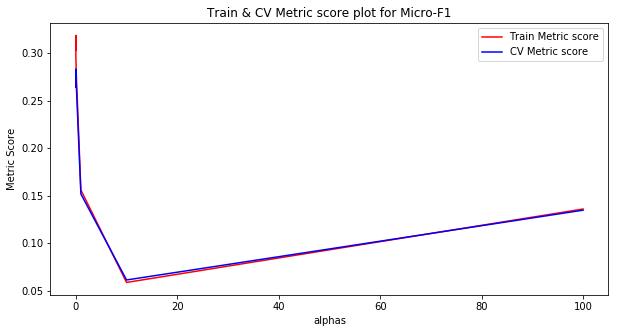

In [14]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [12]:
#Check the test performance with tuned hyper-parameter using grid search
best_alpha = best_estimator.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', alpha = best_alpha), n_jobs=-1)
CheckTestScores(classifier,X_avgfasttext_train,y_train,X_avgfasttext_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 29.71
Macro-Recall score without fixed no of tags: 12.952
Micro-F1 score for fixed 3 tags: 23.94
Macro-Recall score for fixed 3 tags: 9.748
Micro-F1 score for fixed 5 tags: 24.72
Macro-Recall score for fixed 5 tags: 15.377


#### <u>Note</u>: Since  we have less no of dimensions in case of FastText, so the results I got from Logistic regression were not very impressive. Hence I will try random forest on FastText to see whether it improves the results

## Applying Random forest on Average FastText 

In [9]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [10]:
import pickle
with open("X_avgfasttext_train_300dim.pkl","rb") as f:
    X_avgfasttext_train = pickle.load(f)

In [11]:
with open("X_avgfasttext_test_300dim.pkl","rb") as f:
    X_avgfasttext_test = pickle.load(f)

In [12]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x00000224BFA18D90>,
        vocabulary=None)

In [13]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


In [15]:
parameters = {'estimator__n_estimators':[5, 10, 20, 30, 50, 100, 200, 500],'estimator__max_depth':[5, 10, 50, 100, 500, 1000]}
classifier = OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 3, "f1_micro", X_avgfasttext_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 332.3min finished


GridSearchCV took 20599.37 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.318 (std: 0.003)
Parameters: {'estimator__max_depth': 5, 'estimator__n_estimators': 500}

Model with rank: 2
Mean validation score: 0.316 (std: 0.004)
Parameters: {'estimator__max_depth': 5, 'estimator__n_estimators': 200}

Model with rank: 3
Mean validation score: 0.313 (std: 0.003)
Parameters: {'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Model with rank: 4
Mean validation score: 0.309 (std: 0.004)
Parameters: {'estimator__max_depth': 5, 'estimator__n_estimators': 50}

Model with rank: 5
Mean validation score: 0.299 (std: 0.003)
Parameters: {'estimator__max_depth': 5, 'estimator__n_estimators': 30}



In [16]:
#get train and CV data from gridsearch results object
df_cv_results = pd.DataFrame(cv_results)

In [17]:
import pickle
with open("grid_results_RF.pkl","wb") as f:
    pickle.dump(df_cv_results,f)

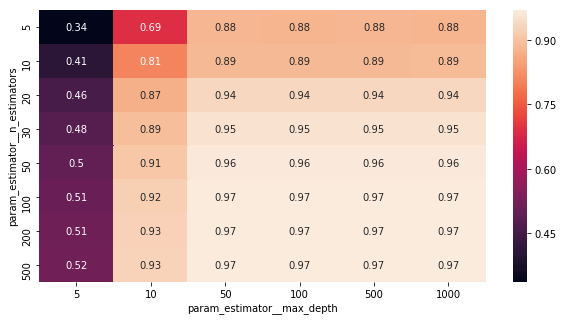

In [18]:
#Visualizing micro-f1 score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_cv_results.pivot(index='param_estimator__n_estimators', columns='param_estimator__max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

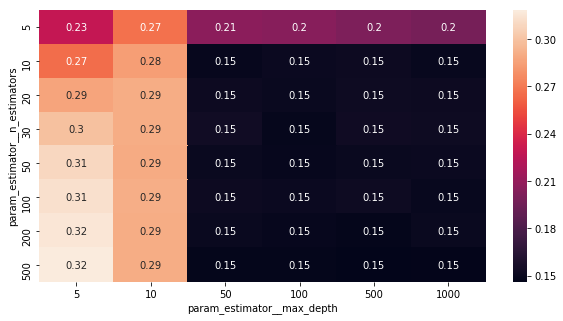

In [19]:
#Visualizing micro-f1 score change with two hyperparameters using a heatmap for test data
plt.figure(figsize = (10, 5))
pivot = df_cv_results.pivot(index='param_estimator__n_estimators', columns='param_estimator__max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

In [26]:
#Check the test performance with tuned hyper-parameter using grid search
optimal_max_depth = best_estimator.get_params()['estimator__max_depth']
optimal_n_estimators = best_estimator.get_params()['estimator__n_estimators']
rfc = OneVsRestClassifier(RandomForestClassifier(class_weight = 'balanced', max_depth = optimal_max_depth, n_estimators = optimal_n_estimators), n_jobs = -1)
CheckTestScores(rfc, X_avgfasttext_train, y_train,X_avgfasttext_test, y_test,bow)

Micro-F1 score without fixed no of tags: 29.61
Macro-Recall score without fixed no of tags: 26.409
Micro-F1 score for fixed 3 tags: 30.39
Macro-Recall score for fixed 3 tags: 13.585
Micro-F1 score for fixed 5 tags: 32.22
Macro-Recall score for fixed 5 tags: 19.663


#### <u>Observation</u>: The results improved with random forest. So now I will try XGBoost to see if I can further improve the results

## Applying GBDT using XGBoost on Average FastText 

In [7]:
df_train_noval = GetSqlDB("df_train_noval.db")
df_test_noval = GetSqlDB("df_test_noval.db")

In [8]:
import pickle
with open("X_avgfasttext_train_300dim.pkl","rb") as f:
    X_avgfasttext_train = pickle.load(f)

In [14]:
 X_avgfasttext_train_arr = np.array(X_avgfasttext_train)

In [9]:
with open("X_avgfasttext_test_300dim.pkl","rb") as f:
    X_avgfasttext_test = pickle.load(f)

In [16]:
 X_avgfasttext_test_arr = np.array(X_avgfasttext_test)

In [10]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x00000194E5EE7510>,
        vocabulary=None)

In [11]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11797, 71)
(2955, 71)


In [17]:
parameters = {'estimator__n_estimators':[5, 10, 20, 30, 50, 100, 200, 500],'estimator__max_depth':[5, 10, 50, 100, 500, 1000]}
classifier = OneVsRestClassifier(xgb.XGBClassifier(colsample_bytree=0.7, colsample_bylevel=0.7), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 3, "f1_micro", X_avgfasttext_train_arr, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 189.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 2288.5min finished


GridSearchCV took 139588.09 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.245 (std: 0.003)
Parameters: {'estimator__max_depth': 5, 'estimator__n_estimators': 500}

Model with rank: 2
Mean validation score: 0.241 (std: 0.005)
Parameters: {'estimator__max_depth': 5, 'estimator__n_estimators': 200}

Model with rank: 3
Mean validation score: 0.232 (std: 0.006)
Parameters: {'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Model with rank: 4
Mean validation score: 0.231 (std: 0.002)
Parameters: {'estimator__max_depth': 10, 'estimator__n_estimators': 500}

Model with rank: 5
Mean validation score: 0.225 (std: 0.005)
Parameters: {'estimator__max_depth': 50, 'estimator__n_estimators': 500}

Model with rank: 5
Mean validation score: 0.225 (std: 0.005)
Parameters: {'estimator__max_depth': 100, 'estimator__n_estimators': 500}

Model with rank: 5
Mean validation score: 0.225 (std: 0.005)
Parameters: {'estimator__max_depth': 500, 'estimator__n_es

In [18]:
#get train and CV data from gridsearch results object
df_cv_results = pd.DataFrame(cv_results)

In [19]:
import pickle
with open("grid_results_XGB_FT.pkl","wb") as f:
    pickle.dump(df_cv_results,f)

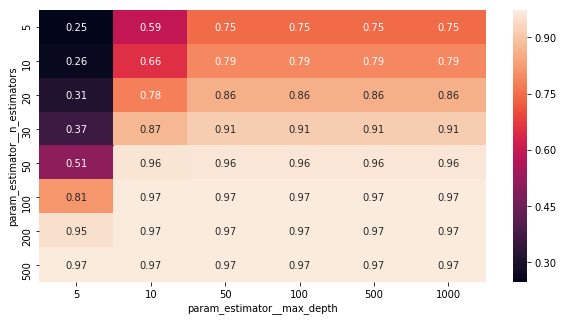

In [20]:
#Visualizing micro-f1 score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_cv_results.pivot(index='param_estimator__n_estimators', columns='param_estimator__max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

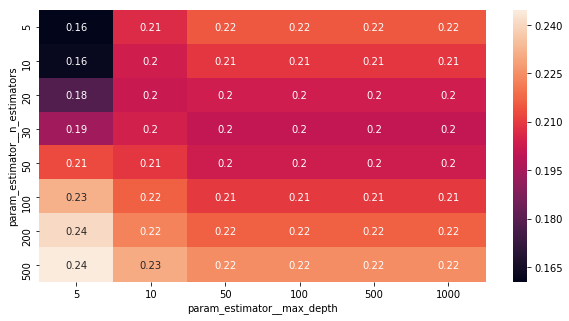

In [21]:
#Visualizing micro-f1 score change with two hyperparameters using a heatmap for test data
plt.figure(figsize = (10, 5))
pivot = df_cv_results.pivot(index='param_estimator__n_estimators', columns='param_estimator__max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

In [23]:
#Check the test performance with tuned hyper-parameter using grid search
optimal_max_depth = best_estimator.get_params()['estimator__max_depth']
optimal_n_estimators = best_estimator.get_params()['estimator__n_estimators']
xgbc = OneVsRestClassifier(xgb.XGBClassifier(max_depth = optimal_max_depth, n_estimators = optimal_n_estimators,
                        colsample_bytree=0.7, colsample_bylevel=0.7), n_jobs = -1)
CheckTestScores(xgbc, X_avgfasttext_train_arr, y_train,X_avgfasttext_test_arr, y_test,bow)

Micro-F1 score without fixed no of tags: 25.57
Macro-Recall score without fixed no of tags: 4.107
Micro-F1 score for fixed 3 tags: 36.00
Macro-Recall score for fixed 3 tags: 8.946
Micro-F1 score for fixed 5 tags: 36.61
Macro-Recall score for fixed 5 tags: 13.863


#### <u>Observation</u>: The results definitely improved woth XGBoost (one of the best results I got)

## <u>4.5: Using Stanford NLP to extract agent verbs and patient verbs</u>
Refer: https://nlp.stanford.edu/software/stanford-dependencies.shtml#English

In [3]:
#method that print dependencies for a given movie
#import pdb
from tqdm import tqdm
def GetSynopisDependencies(dataset):
    nlp = stanfordnlp.Pipeline()
    dictSynopsisDependecies = {}
    for index, row in tqdm(final.iterrows()):
        synopis_document = row['plot_synopsis']
        movie_title = row['title']
        list_of_dependencies = []
        doc = nlp(synopis_document)      
        for sentence in doc.sentences:
            #sentence.print_dependencies()
            list_of_dependencies.append(sentence.dependencies)
        dictSynopsisDependecies[movie_title] = list_of_dependencies
    return dictSynopsisDependecies

In [4]:
dictSynopsisDependecies = GetSynopisDependencies(final)

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': 'C:\\Users\\prateeksood\\stanfordnlp_resources\\en_ewt_models\\en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': 'C:\\Users\\prateeksood\\stanfordnlp_resources\\en_ewt_models\\en_ewt_tagger.pt', 'pretrain_path': 'C:\\Users\\prateeksood\\stanfordnlp_resources\\en_ewt_models\\en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': 'C:\\Users\\prateeksood\\stanfordnlp_resources\\en_ewt_models\\en_ewt_lemmatizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': 'C:\\Users\\prateeksood\\stanfordnlp_resources\\en_ewt_models\\en_ewt_parser.pt', 'pret

14752it [23:09:50,  4.08s/it]


In [3]:
import pickle
with open("dictSynopsisDependecies.pkl","rb") as f:
    dictSynopsisDependecies = pickle.load(f)

In [88]:
from tqdm import tqdm
def GetSynopsisWordDependenciesRefined(dictSynopsisDependecies):
    dictSynopsisDepRefined = {}
    for movie_title,synopsis_doc in tqdm(dictSynopsisDependecies.items()):
        list_word_tuples = []
        for sentences in synopsis_doc:
            for sentence in sentences:
                for word in sentence:
                    if(type(word) == stanfordnlp.pipeline.doc.Word):
                        word_tuple = (word.lemma,word.dependency_relation)
                        list_word_tuples.append(word_tuple)
        word_dependency_tuples = set(list_word_tuples)
        dictSynopsisDepRefined[movie_title] = word_dependency_tuples
    return dictSynopsisDepRefined

In [89]:
dictSynopsisDepRefined = GetSynopsisWordDependenciesRefined(dictSynopsisDependecies)

100%|████████████████████████████████████████████████████████████████████████████| 13746/13746 [02:20<00:00, 97.87it/s]


In [2]:
import pickle
with open("dictSynopsisDepRefined.pkl","rb") as f:
    dictSynopsisDepRefined = pickle.load(f)

In [3]:
#get information about dependencies, action verbs, agent verbs, patient verbs
from tqdm import tqdm
unique_dep = []
all_action_verbs = []
all_agent_verbs = []
all_patient_verbs = []
for movie_title,dependencies in tqdm(dictSynopsisDepRefined.items()):
    for item in dependencies:
        dependecy = item[1]
        if dependecy not in unique_dep:
            unique_dep.append(dependecy)
        if dependecy == 'nsubj' or dependecy == 'nsubj:pass' or dependecy == 'obj' or dependecy == 'iobj':
            if item[0] not in all_action_verbs:
                all_action_verbs.append(item[0])
        if dependecy == 'nsubj':
            if item[0] not in all_agent_verbs:
                all_agent_verbs.append(item[0])
        elif dependecy == 'nsubj:pass' or dependecy == 'obj' or dependecy == 'iobj':
            if item[0] not in all_patient_verbs:
                all_patient_verbs.append(item[0])

100%|████████████████████████████████████████████████████████████████████████████| 13746/13746 [03:55<00:00, 58.26it/s]


In [85]:
print("Total no of dependency relations found are: " + str(len(unique_dep)))
print("Total no of unique action verbs are: " + str(len(all_action_verbs)))
print("Total no of unique agent verbs are: " + str(len(all_agent_verbs)))
print("Total no of unique patient verbs are: " + str(len(all_patient_verbs)))

Total no of dependency relations found are: 49
Total no of unique action verbs are: 47226
Total no of unique agent verbs are: 34961
Total no of unique patient verbs are: 37303


In [80]:
#we need to extract agent verbs(nsubj)
dictMovieAgentVerbs = {}
for movie_title,dependencies in dictSynopsisDepRefined.items():
    movie_agent_verbs = []
    for item in dependencies:
        dependecy = item[1]
        if(dependecy == 'nsubj' and item[0] not in movie_agent_verbs):
            movie_agent_verbs.append(item[0])
    dictMovieAgentVerbs[movie_title] = movie_agent_verbs

In [82]:
#we need to extract patient verbs(nsubj:pass, obj, iobj)
dictMoviePatientVerbs = {}
for movie_title,dependencies in dictSynopsisDepRefined.items():
    movie_patient_verbs = []
    for item in dependencies:
        dependecy = item[1]
        if(dependecy == 'nsubj:pass' or dependecy == 'obj' or dependecy == 'iobj'):
            if item[0] not in movie_patient_verbs:
                movie_patient_verbs.append(item[0])
    dictMoviePatientVerbs[movie_title] = movie_patient_verbs

In [6]:
#use fasttext to embed the action verbs
from gensim.models import KeyedVectors
en_model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

In [7]:
fasttext_words = list(en_model.wv.vocab)

In [15]:
#writing code to vectorize action verbs
from tqdm import tqdm
#import pdb
action_verb_vectors = []
for verb in tqdm(all_action_verbs):
    if(verb in fasttext_words):
        action_verb_vectors.append(en_model.wv[verb])

100%|████████████████████████████████████████████████████████████████████████████| 47226/47226 [08:39<00:00, 90.83it/s]


In [16]:
print(len(action_verb_vectors))
print(len(action_verb_vectors[0]))

25452
300


In [89]:
#writing code to vectorize agent verbs
from tqdm import tqdm
#import pdb
agent_verb_vectors = []
for verb in all_agent_verbs:
    if(verb in fasttext_words):
        agent_verb_vectors.append(en_model.wv[verb])

In [90]:
print(len(agent_verb_vectors))
print(len(agent_verb_vectors[0]))

18510
300


In [91]:
#writing code to vectorize patient verbs
from tqdm import tqdm
#import pdb
patient_verb_vectors = []
for verb in tqdm(all_patient_verbs):
    if(verb in fasttext_words):
        patient_verb_vectors.append(en_model.wv[verb])

100%|████████████████████████████████████████████████████████████████████████████| 37303/37303 [06:38<00:00, 93.71it/s]


In [92]:
print(len(patient_verb_vectors))
print(len(patient_verb_vectors[0]))

22316
300


In [13]:
import pickle
with open("dictMovieVerbs.pkl","rb") as f:
    dictMovieVerbs = pickle.load(f)
with open("dictMovieAgentVerbs.pkl","rb") as f:
     dictMovieAgentVerbs = pickle.load(f)
with open("dictMoviePatientVerbs.pkl","rb") as f:
     dictMoviePatientVerbs = pickle.load(f)
with open("all_action_verbs.pkl","rb") as f:
    all_action_verbs = pickle.load(f)
with open("all_agent_verbs.pkl","rb") as f:
    all_agent_verbs = pickle.load(f)
with open("all_patient_verbs.pkl","rb") as f:
    all_patient_verbs = pickle.load(f)
with open("action_verb_vectors.pkl","rb") as f:
    action_verb_vectors = pickle.load(f)
with open("agent_verb_vectors.pkl","rb") as f:
    agent_verb_vectors = pickle.load(f)
with open("patient_verb_vectors.pkl","rb") as f:
    patient_verb_vectors = pickle.load(f)

### Applying Kmeans on agent verbs word embeddings

In [94]:
from sklearn.cluster import KMeans
KValue = 500 #we have selected K=500 as it gives the best results
kmeans_agent = KMeans(n_clusters=KValue, init='k-means++', n_init=5, max_iter=300, n_jobs=-1)
kmeans_agent.fit(agent_verb_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=500, n_init=5, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [5]:
with open("kmeans_agent.pkl","rb") as f:
    kmeans_agent = pickle.load(f)

In [8]:
#writing code to include only those agent verbs that are part of fast-text wikipedia embedding
from tqdm import tqdm
all_agent_verbs_ft = []
for verb in tqdm(all_agent_verbs):
    if(verb in fasttext_words):
        all_agent_verbs_ft.append(verb)

100%|████████████████████████████████████████████████████████████████████████████| 34961/34961 [06:27<00:00, 90.24it/s]


In [9]:
import pickle
with open("all_action_verbs_ft.pkl","rb") as f:
     all_action_verbs_ft = pickle.load(f)

In [16]:
#get the distribution of agent verb clusters over the movie synopsis
from tqdm import tqdm
#import pdb
dictMovieAgentClusterVectors = {}
for movie_title,verbs in tqdm(dictMovieAgentVerbs.items()):
    cluster_vector = np.zeros(500)
    for verb in verbs:
        if verb in fasttext_words:
            cluster_label = kmeans_agent.labels_[all_agent_verbs_ft.index(verb)]
            cluster_vector[cluster_label] += 1
    dictMovieAgentClusterVectors[movie_title] = cluster_vector

100%|████████████████████████████████████████████████████████████████████████████| 13746/13746 [13:28<00:00, 19.07it/s]


### Applying Kmeans on patient verbs word embeddings

In [18]:
from sklearn.cluster import KMeans
KValue = 500
kmeans_patient = KMeans(n_clusters=KValue, init='k-means++', n_init=5, max_iter=300, n_jobs=-1)
kmeans_patient.fit(patient_verb_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=500, n_init=5, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
with open("kmeans_patient.pkl","wb") as f:
     pickle.dump(kmeans_patient,f)

In [5]:
with open("kmeans_patient.pkl","rb") as f:
    kmeans_patient = pickle.load(f)

In [20]:
#writing code to include only those agent verbs that are part of fast-text wikipedia embedding
from tqdm import tqdm
all_patient_verbs_ft = []
for verb in tqdm(all_patient_verbs):
    if(verb in fasttext_words):
        all_patient_verbs_ft.append(verb)

100%|████████████████████████████████████████████████████████████████████████████| 37303/37303 [06:18<00:00, 98.67it/s]


In [21]:
import pickle
with open("all_patient_verbs_ft.pkl","wb") as f:
      pickle.dump(all_patient_verbs_ft,f)

In [9]:
import pickle
with open("all_patient_verbs_ft.pkl","rb") as f:
     all_patient_verbs_ft = pickle.load(f)

In [22]:
#get the distribution of agent verb clusters over the movie synopsis
from tqdm import tqdm
#import pdb
dictMoviePatientClusterVectors = {}
for movie_title,verbs in tqdm(dictMoviePatientVerbs.items()):
    cluster_vector = np.zeros(500)
    for verb in verbs:
        if verb in fasttext_words:
            cluster_label = kmeans_patient.labels_[all_patient_verbs_ft.index(verb)]
            cluster_vector[cluster_label] += 1
    dictMoviePatientClusterVectors[movie_title] = cluster_vector

100%|████████████████████████████████████████████████████████████████████████████| 13746/13746 [12:35<00:00, 19.00it/s]


In [6]:
#get the whole data grouped by title to remove duplicate titles
con = sqlite3.connect("cleaned_data.sqlite") 
df = pd.read_sql_query("select title,Cleaned_synopsis,tags,split from Movie_Synopsis group by title", con)
con.close()

In [7]:
import pickle
with open("dictMovieAgentClusterVectors.pkl","rb") as f:
      dictMovieAgentClusterVectors = pickle.load(f)

In [8]:
df_agent_verb = pd.DataFrame.from_dict(dictMovieAgentClusterVectors, orient='index') 
df_agent_verb = df_agent_verb.assign(tags=df["tags"].values)
df_agent_verb = df_agent_verb.assign(split=df["split"].values)

In [9]:
df_train_noval = df_agent_verb[df_agent_verb['split'] != 'test']
df_test_noval = df_agent_verb[df_agent_verb['split'] == 'test']

In [16]:
df_train_noval.head(5)

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,tags,split
$windle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flashback,train
'71,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"suspenseful, neo noir, murder, violence",train
'a' gai wak,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"cult, violence",train
'breaker' morant,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"murder, anti war, violence, flashback, tragedy...",train
'c'-man,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,murder,train


In [10]:
X_agent_verbs_train = df_train_noval.iloc[:,0:-2]
X_agent_verbs_test = df_test_noval.iloc[:,0:-2]

In [11]:
print(X_agent_verbs_train.shape)
print(X_agent_verbs_test.shape)

(11005, 500)
(2741, 500)


In [12]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x0000018BEC9A6378>,
        vocabulary=None)

### Using Agent verbs to predict tags

In [14]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11005, 71)
(2741, 71)


#### Using GridSearchCV to find the optimal parameter values

In [15]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_agent_verbs_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.3min finished


GridSearchCV took 146.59 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.146 (std: 0.020)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 2
Mean validation score: 0.140 (std: 0.072)
Parameters: {'estimator__alpha': 10}

Model with rank: 3
Mean validation score: 0.138 (std: 0.048)
Parameters: {'estimator__alpha': 100}

Model with rank: 4
Mean validation score: 0.092 (std: 0.029)
Parameters: {'estimator__alpha': 0.0001}

Model with rank: 5
Mean validation score: 0.014 (std: 0.014)
Parameters: {'estimator__alpha': 0.001}



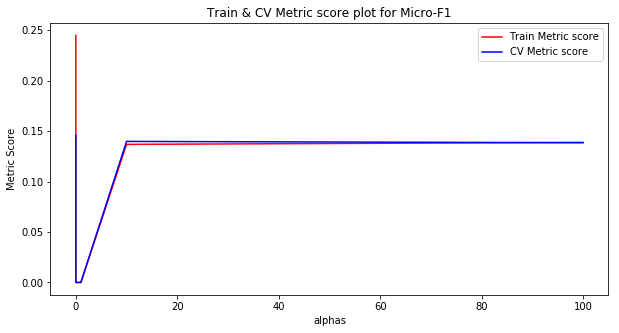

In [16]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [22]:
#Check the test performance with tuned hyper-parameter using grid search
#best_alpha = best_estimator.get_params()['estimator__alpha']
best_alpha = 10**-5
CheckTestScores(X_agent_verbs_train,y_train,X_agent_verbs_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 11.23
Macro-Recall score without fixed no of tags: 3.609
Micro-F1 score for fixed 3 tags: 12.24
Macro-Recall score for fixed 3 tags: 4.156
Micro-F1 score for fixed 5 tags: 15.07
Macro-Recall score for fixed 5 tags: 7.173


#### <u>Note</u>: Since  we have less no of dimensions in case of Agent verbs, so the results I got from Logistic regression were not very impressive. Hence I will try random forest on agent verbs to see whether it improves the results

## Random Forest on Agent Verbs

In [13]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11005, 71)
(2741, 71)


#### Using GridSearchCV to find the optimal alpha value

In [14]:
parameters = {'estimator__n_estimators':[5, 10, 20, 30, 50, 100, 200, 500],'estimator__max_depth':[5, 10, 50, 100, 500, 1000]}
classifier = OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 3, "f1_micro", X_agent_verbs_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 126.1min finished


GridSearchCV took 7574.55 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.115 (std: 0.005)
Parameters: {'estimator__max_depth': 500, 'estimator__n_estimators': 5}

Model with rank: 2
Mean validation score: 0.114 (std: 0.003)
Parameters: {'estimator__max_depth': 1000, 'estimator__n_estimators': 5}

Model with rank: 3
Mean validation score: 0.107 (std: 0.002)
Parameters: {'estimator__max_depth': 100, 'estimator__n_estimators': 5}

Model with rank: 4
Mean validation score: 0.086 (std: 0.001)
Parameters: {'estimator__max_depth': 50, 'estimator__n_estimators': 5}

Model with rank: 5
Mean validation score: 0.071 (std: 0.001)
Parameters: {'estimator__max_depth': 100, 'estimator__n_estimators': 10}



In [15]:
#get train and CV data from gridsearch results object
df_cv_results = pd.DataFrame(cv_results)

In [16]:
import pickle
with open("grid_results_RF_agent.pkl","wb") as f:
    pickle.dump(df_cv_results,f)

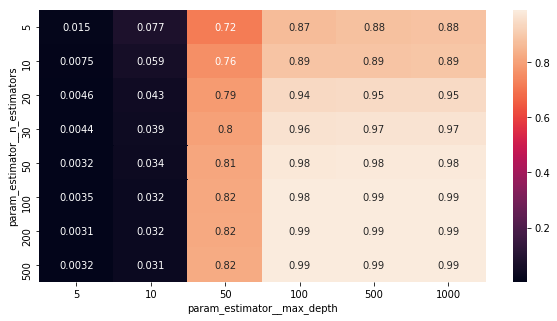

In [17]:
#Visualizing micro-f1 score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_cv_results.pivot(index='param_estimator__n_estimators', columns='param_estimator__max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

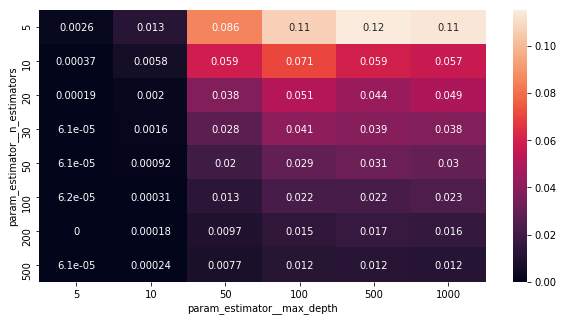

In [18]:
#Visualizing micro-f1 score change with two hyperparameters using a heatmap for test data
plt.figure(figsize = (10, 5))
pivot = df_cv_results.pivot(index='param_estimator__n_estimators', columns='param_estimator__max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

In [21]:
#Check the test performance with tuned hyper-parameter using grid search
optimal_max_depth = best_estimator.get_params()['estimator__max_depth']
optimal_n_estimators = best_estimator.get_params()['estimator__n_estimators']
rfc = OneVsRestClassifier(RandomForestClassifier(max_depth = optimal_max_depth, n_estimators = optimal_n_estimators), n_jobs = -1)
CheckTestScores(rfc, X_agent_verbs_train, y_train,X_agent_verbs_test, y_test,bow)

Micro-F1 score without fixed no of tags: 12.27
Macro-Recall score without fixed no of tags: 1.285
Micro-F1 score for fixed 3 tags: 20.55
Macro-Recall score for fixed 3 tags: 4.157
Micro-F1 score for fixed 5 tags: 21.43
Macro-Recall score for fixed 5 tags: 6.963


#### <u>Observation</u>: Even though results did improve with random forest but results are not satisfactory (One of the poorest performing results). Hence I will skip XGBoost as it is unlikely to give exceptional results

## <u>Patient verbs</u>

In [7]:
#get the whole data grouped by title to remove duplicate titles
con = sqlite3.connect("cleaned_data_maxtags.sqlite") 
df = pd.read_sql_query("select title,Cleaned_synopsis,tags,split from Movie_Synopsis group by title", con)
con.close()

In [8]:
import pickle
with open("dictMoviePatientClusterVectors.pkl","rb") as f:
      dictMoviePatientClusterVectors = pickle.load(f)

In [9]:
df_patient_verb = pd.DataFrame.from_dict(dictMoviePatientClusterVectors, orient='index') 
df_patient_verb = df_patient_verb.assign(tags=df["tags"].values)
df_patient_verb = df_patient_verb.assign(split=df["split"].values)

In [10]:
df_train_noval = df_patient_verb[df_patient_verb['split'] != 'test']
df_test_noval = df_patient_verb[df_patient_verb['split'] == 'test']

In [11]:
X_patient_verbs_train = df_train_noval.iloc[:,0:-4]
X_patient_verbs_test = df_test_noval.iloc[:,0:-4]

In [12]:
print(X_patient_verbs_train.shape)
print(X_patient_verbs_test.shape)

(11005, 498)
(2741, 498)


In [14]:
bow = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
bow.fit(df_train_noval["tags"])

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x0000016ABCD252F0>,
        vocabulary=None)

### Using Patient verbs to predict tags

In [16]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11005, 71)
(2741, 71)


#### Using GridSearchCV to find the optimal alpha value

In [15]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {"estimator__alpha": [10 ** x for x in range(-5, 3)]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 5, "f1_micro", X_patient_verbs_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.6min finished


GridSearchCV took 165.05 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.141 (std: 0.044)
Parameters: {'estimator__alpha': 0.0001}

Model with rank: 2
Mean validation score: 0.126 (std: 0.035)
Parameters: {'estimator__alpha': 1e-05}

Model with rank: 3
Mean validation score: 0.113 (std: 0.081)
Parameters: {'estimator__alpha': 100}

Model with rank: 4
Mean validation score: 0.079 (std: 0.097)
Parameters: {'estimator__alpha': 10}

Model with rank: 5
Mean validation score: 0.030 (std: 0.022)
Parameters: {'estimator__alpha': 0.001}



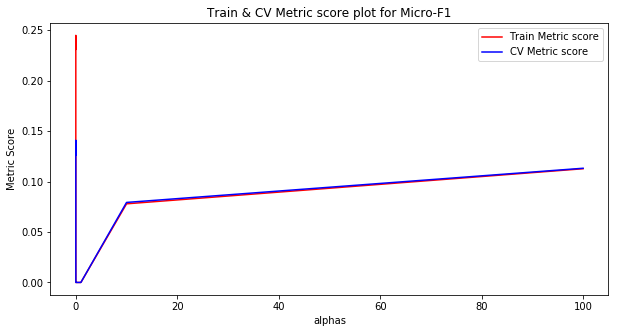

In [16]:
PlotTrainVsCVerror(cv_results, "Micro-F1")

In [14]:
#Check the test performance with tuned hyper-parameter using grid search
best_alpha = best_estimator.get_params()['estimator__alpha']
CheckTestScores(X_patient_verbs_train,y_train,X_patient_verbs_test,y_test,best_alpha,bow)

Micro-F1 score without fixed no of tags: 7.64
Macro-Recall score without fixed no of tags: 1.649
Micro-F1 score for fixed 3 tags: 16.46
Macro-Recall score for fixed 3 tags: 3.912
Micro-F1 score for fixed 5 tags: 20.61
Macro-Recall score for fixed 5 tags: 6.768


#### <u>Note</u>: Since  we have less no of dimensions in case of Patient verbs, so the results I got from Logistic regression were not very impressive. Hence I will try random forest on agent verbs to see whether it improves the results

## Random Forest on Patient Verbs

In [17]:
y_train = bow.transform(df_train_noval["tags"])
print(y_train.shape)
y_test = bow.transform(df_test_noval["tags"])
print(y_test.shape)

(11005, 71)
(2741, 71)


#### Using GridSearchCV to find the optimal parameters values

In [18]:
parameters = {'estimator__n_estimators':[5, 10, 20, 30, 50, 100, 200, 500],'estimator__max_depth':[5, 10, 50, 100, 500, 1000]}
classifier = OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1)
cv_results,best_score,best_estimator = PerformGridSearchCV(classifier,parameters, 3, "f1_micro", X_patient_verbs_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 109.9min finished


GridSearchCV took 6600.97 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.117 (std: 0.002)
Parameters: {'estimator__max_depth': 100, 'estimator__n_estimators': 5}

Model with rank: 2
Mean validation score: 0.117 (std: 0.004)
Parameters: {'estimator__max_depth': 1000, 'estimator__n_estimators': 5}

Model with rank: 3
Mean validation score: 0.115 (std: 0.003)
Parameters: {'estimator__max_depth': 500, 'estimator__n_estimators': 5}

Model with rank: 4
Mean validation score: 0.101 (std: 0.004)
Parameters: {'estimator__max_depth': 50, 'estimator__n_estimators': 5}

Model with rank: 5
Mean validation score: 0.065 (std: 0.003)
Parameters: {'estimator__max_depth': 50, 'estimator__n_estimators': 10}



In [19]:
#get train and CV data from gridsearch results object
df_cv_results = pd.DataFrame(cv_results)

In [20]:
import pickle
with open("grid_results_RF_patient.pkl","wb") as f:
    pickle.dump(df_cv_results,f)

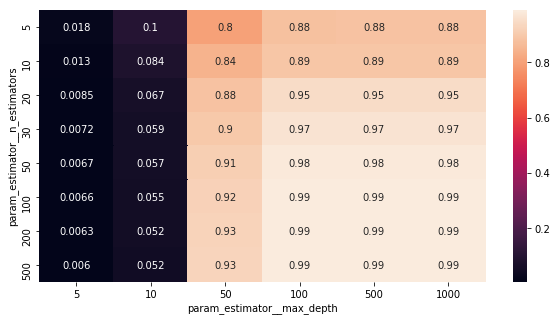

In [21]:
#Visualizing micro-f1 score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_cv_results.pivot(index='param_estimator__n_estimators', columns='param_estimator__max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

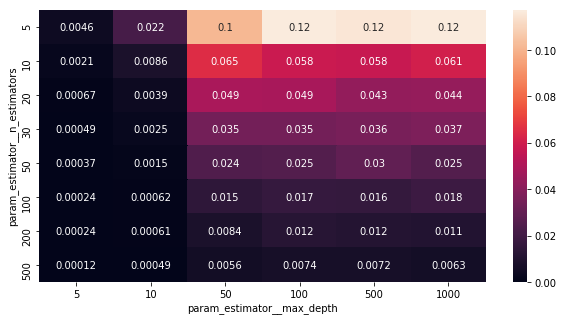

In [22]:
#Visualizing micro-f1 score change with two hyperparameters using a heatmap for test data
plt.figure(figsize = (10, 5))
pivot = df_cv_results.pivot(index='param_estimator__n_estimators', columns='param_estimator__max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

In [23]:
#Check the test performance with tuned hyper-parameter using grid search
optimal_max_depth = best_estimator.get_params()['estimator__max_depth']
optimal_n_estimators = best_estimator.get_params()['estimator__n_estimators']
rfc = OneVsRestClassifier(RandomForestClassifier(max_depth = optimal_max_depth, n_estimators = optimal_n_estimators), n_jobs = -1)
CheckTestScores(rfc, X_patient_verbs_train, y_train,X_patient_verbs_test, y_test,bow)

Micro-F1 score without fixed no of tags: 11.93
Macro-Recall score without fixed no of tags: 1.235
Micro-F1 score for fixed 3 tags: 21.01
Macro-Recall score for fixed 3 tags: 4.319
Micro-F1 score for fixed 5 tags: 21.96
Macro-Recall score for fixed 5 tags: 7.397


#### <u>Observation</u>: Even though results did improve with random forest but results are not satisfactory (One of the poorest performing results). Hence I will skip XGBoost as it is unlikely to give exceptional results

#### <u>Observation</u>: The experimentation with agent and patient verbs did not yield good results and they did not prove to be effective features for predicting tags

## <u>Summary of results</u>

In [21]:
#Printing results for logistic regression
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Best alpha", "MicroF1", "MacroRecall","MicroF1-3 tags","MacroRecall-3 tags","MicroF1-5 tags","MacroRecall-5 tags"]
x.add_row(["Random", "NA", "NA", "NA",2.04,4.225,1.01,7.042])
x.add_row(["Major", "NA", "NA", "NA",29.74,4.225,31.91,7.042])
x.add_row(["1Gram",10**-5, 30.07, 7.139,33.75,11.199,34.19,17.016])
x.add_row(["2Gram",100, 25.01, 2.964,35.79,6.837,35.62,10.153])
x.add_row(["3Gram",100, 9.43, 0.750,30.78,4.700,32.54,7.577])
x.add_row(["123Gram",10**-5, 35.21, 9.429,36.04,11.277,36.23,16.849])
x.add_row(["char3Gram",10**-5, 30.02, 6.037,33.58,11.241,33.63,17.244])
x.add_row(["char4Gram",10**-5, 29.24, 5.583,34.62,10.650,35.04,16.877])
x.add_row(["char34Gram",10**-5, 29.09, 5.111,35.36,10.514,35.49,16.417])
x.add_row(["2skip2Gram",10**-5, 21.96, 1.988,35.17,6.115,35.19,9.078])
x.add_row(["Fast-Text",0.001, 29.71, 12.952,23.94,9.748,24.72,15.377])
x.add_row(["A-verbs",10**-5, 11.23, 3.609,12.24,4.156,15.07,7.173])
x.add_row(["P-verbs",0.0001, 7.64, 1.649,16.46,3.912,20.61,6.768])
print("Results for Logistic regression models")
print(x)

Results for Logistic regression models
+------------+------------+---------+-------------+----------------+--------------------+----------------+--------------------+
|   Model    | Best alpha | MicroF1 | MacroRecall | MicroF1-3 tags | MacroRecall-3 tags | MicroF1-5 tags | MacroRecall-5 tags |
+------------+------------+---------+-------------+----------------+--------------------+----------------+--------------------+
|   Random   |     NA     |    NA   |      NA     |      2.04      |       4.225        |      1.01      |       7.042        |
|   Major    |     NA     |    NA   |      NA     |     29.74      |       4.225        |     31.91      |       7.042        |
|   1Gram    |   1e-05    |  30.07  |    7.139    |     33.75      |       11.199       |     34.19      |       17.016       |
|   2Gram    |    100     |  25.01  |    2.964    |     35.79      |       6.837        |     35.62      |       10.153       |
|   3Gram    |    100     |   9.43  |     0.75    |     30.78    

In [28]:
#Printing results for Random Forest and XGBoost
x = PrettyTable()
x.field_names = ["Model","n_estimators","max_depth","MicF1", "MacRecall","MicF1-3tags","MacRecall-3tags","MicF1-5tags","MacRecall-5Tags"]
x.add_row(["FastText",500,5, 29.61, 26.409,30.39,13.585,32.22,19.663])
x.add_row(["F-Text(XGB)",500,5, 25.57, 4.107,36.00,8.946,36.61,13.863])
x.add_row(["A-verbs",500,5, 12.27, 1.285,20.55,4.157,21.43,6.963])
x.add_row(["P-verbs",100,5, 11.93, 1.235,21.01,4.319,21.96,7.397])
print("Results for Random Forest and XGBoost")
print(x)

Results for Random Forest and XGBoost
+-------------+--------------+-----------+-------+-----------+-------------+-----------------+-------------+-----------------+
|    Model    | n_estimators | max_depth | MicF1 | MacRecall | MicF1-3tags | MacRecall-3tags | MicF1-5tags | MacRecall-5Tags |
+-------------+--------------+-----------+-------+-----------+-------------+-----------------+-------------+-----------------+
|   FastText  |     500      |     5     | 29.61 |   26.409  |    30.39    |      13.585     |    32.22    |      19.663     |
| F-Text(XGB) |     500      |     5     | 25.57 |   4.107   |     36.0    |      8.946      |    36.61    |      13.863     |
|   A-verbs   |     500      |     5     | 12.27 |   1.285   |    20.55    |      4.157      |    21.43    |      6.963      |
|   P-verbs   |     100      |     5     | 11.93 |   1.235   |    21.01    |      4.319      |    21.96    |      7.397      |
+-------------+--------------+-----------+-------+-----------+-----------

### <u>Observation</u>: Overall the uni+bi+Tri gram TFIDF gave me the best overall performace in terms of both micro-F1 and macro-recall score. It performed equally well for all three scenarios (no fixed tags, 3 fixed tags and 5 fixed tags)